In [ ]:
# !!! only run when using colab !!!
import os
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
os.chdir("/content/CPlantBox/")
! cmake .
! make
os.chdir("/content/CPlantBox/tutorial/jupyter/workshop_11_2_2022/")

# Workshop 11.2.2022 - (3/3)

## Simulation of xylem water movement 

For calculation of xylem water movement it is necessary to describe the matric potential around the root segments. In the following example we consider a static root system and a static soil. 

The soil is either coupled 

1. per a matric potential around each segment, or 

2. the soil matric potentials are given in a soil domain. Each segment is located within a soil cell. 

The second approach is necessary if we extend the method to a dynamic soil. 

To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017).

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

In the following we will show how to compute water xylem flux, standard uptake fraction (SUF), root sytem conductance (Krs), and show how the mapping between root segments and soil cells is realized. 

In [1]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
import vtk_plot as vp
from xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt

## 1. Matric potentials per root segment

We start with a minimal example with constant conductivities (based on *example6b_xylemflux.py*), where we give the matric potential per segment

In [6]:
""" root system """
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -300  # top soil pressure [cm]
p0 = -500  # dircichlet bc at top [cm]

""" prepare soil matric potentials per segment"""
segs = rs.segments # MappedRootSystem has access to segments and nodes 
nodes = rs.nodes
p_s = np.zeros((len(segs),))
for i, s in enumerate(segs):
    p_s[i] = p_top - 0.5 * (nodes[s.x].z + nodes[s.y].z)  # constant total potential (hydraulic equilibrium)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
trans = -1.185  # cm3
# rx = r.solve_neumann(simtime, trans, p_s, cells = False) #  simulation time, value, soil matric potentials, cells, soil_k=[]
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) # simulation time, value, (unused), soil matric potentials, cells, soil_k=[]
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000, soil_k = []) 
# simulation time, value, soil matric potential around root collar, soil matric potentials, wilting_point, cells, soil_k=[]
fluxes = r.segFluxes(simtime, rx, -200 * np.ones(rx.shape), False)  # cm3/day
print("Transpiration", r.collar_flux(simtime, rx, [p_s]), "cm3/day")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
ana.addData("rx", rx)
ana.addData("fluxes", fluxes)  # cut off for vizualisation
a = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)")  # "rx" fluxes", subType

Transpiration -1.1849999999999832 cm3/day


Age dependent concuctivities (some examples are in CPlantBox/src/python_modules/root_conductivities.py)

other choices to set the conductivities


Artifical shoot kx = 1, kr = 0 
SubType 1 for negative age: kx = 0.0432, kr = 0.0001728
SubType 2 for negative age: kx = 0.0432, kr = 0.0001728
SubType 3 for negative age: kx = 0.0432, kr = 0.0001728
SubType 4 for negative age: kx = 0.0432, kr = 0.0001728
SubType 2 old : kx = 0.0432, kr = 0.0001728



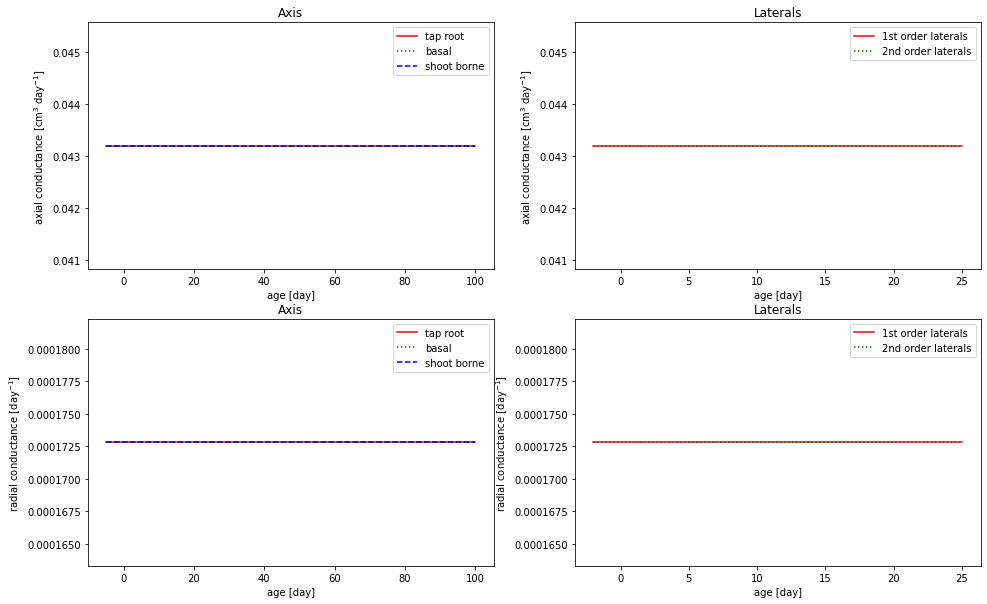

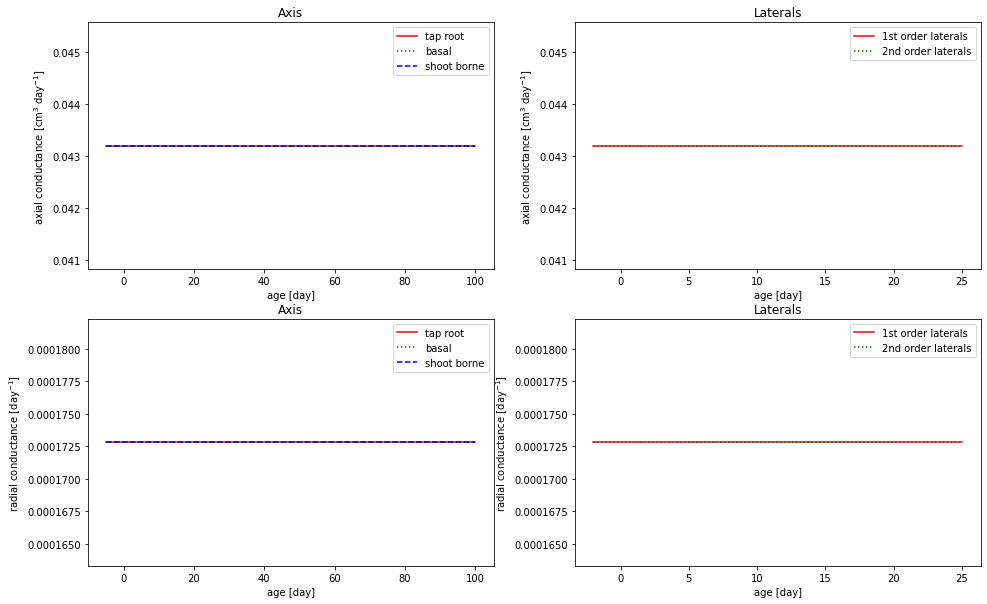

In [8]:
r.plot_conductivities()

In [ ]:
soil_index = lambda x, y, z: 0 # only one cell, all roots are connected to cell 0
r.rs.setSoilGrid(soil_index) 